In [5]:
# %load my_class.py
"""
This module provides a class with 6 methods
"""

import os
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt


class Group22:
    """
    A class to to examine a dataset on agriculture.

    ...

    Attributes
    ----------
    url : str
        url of dataset
    filename : str
        filename of dataset

    Methods
    -------
    download_data:
        downloads the dataset and turns it into a pandas dataframe
    """

    def __init__(self, url, filename):
        """
        Constructs all the necessary attributes for the class object.

        Parameters
        ----------
        url : str
            url of dataset
        filename : str
            filename of dataset
        """
        self.url = url
        self.filename = filename

    def download_data(self):
        """
        Returns a dataframe from the dataset

        Parameters
        ----------
        None

        Returns
        -------
        dataframe
        """
        if not os.path.exists(os.path.join("downloads", self.filename)):
            response = requests.get(self.url)
            if response.status_code == 200:
                with open(os.path.join("downloads", self.filename), "wb") as my_f:
                    my_f.write(response.content)
                print(f"{self.filename} has been downloaded")
            else:
                print(f"Error downloading {self.filename}: {response.status_code}")
        else:
            print(f"{self.filename} already exists")

        data_path = os.path.join("downloads", self.filename)
        my_df = pd.read_csv(data_path, on_bad_lines="skip")

        self.my_df = my_df

        return my_df

    def get_countries(self, my_df):
        """
        Returns a list of all the countries of the dataset

        Parameters
        ----------
        df : pandas dataframe
            dataframe of the dataset

        Returns
        -------
        list
        """
        return list(my_df["Entity"].unique())

    def plot_quantity_correlation(self, my_df):
        """
        Returns a correlation matrix of the quantity columns

        Parameters
        ----------
        df : pandas dataframe
            dataframe of the dataset

        Returns
        -------
        correlation matrix
        """
        quantity_cols = [col for col in my_df.columns if "_quantity" in col]
        quantity_df = my_df[quantity_cols]
        corr_matrix = quantity_df.corr()

        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
        plt.title("Correlation Matrix of Quantity Columns")
        plt.show()

    def plot_output_area_chart(self, my_df, country=None, normalize=False):
        """
        Plots an area chart of the distinct "_output_" columns.

        Parameters
        ----------
        df : pandas dataframe
            dataframe of the dataset
        country : str or None
            Country name. If None or 'World', plots the sum for all countries.
        normalize : bool
            If True, normalizes the output in relative terms:
            each year, output should always be 100%.

        Returns
        -------
        area chart of the distinct "_output_" columns
        """
        output_cols = [col for col in self.my_df.columns if "_output_" in col]
        if not output_cols:
            raise ValueError("No output columns found in the dataset.")

        if country is None or country == "World":
            df_country = pd.DataFrame(self.my_df).groupby("Year")[output_cols].sum().reset_index()
            title = "World Output"
        else:
            if country not in self.get_countries(my_df):
                raise ValueError(f"{country} is not a valid country name.")
            df_country = self.my_df[self.my_df["Entity"] == country][["Year"] + output_cols]
            title = f"{country} Output"

        if normalize:
            df_country[output_cols] = (
                df_country[output_cols].div(df_country[output_cols].sum(axis=1), axis=0)
                * 100
            )

        df_country.set_index("Year").plot(kind="area", stacked=True)
        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Output")
        plt.show()
        
    def compare_output_countries(self, my_df, countries):
        """
        Plots a comparison of the total of the '_output_' column for each of the given countries.

        Parameters:
        ----------
        df : pandas dataframe
            dataframe of the dataset
        country : str or list
            country names to compare

        Returns
        -------
        line graph of total '_output_' columns of given countries over the years
        """
        # Create total output column
        output_cols = [col for col in self.my_df.columns if '_output_' in col]
        my_df['total_output'] = self.my_df[output_cols].sum(axis=1)

        # Transform input to list
        if not isinstance(countries, list):
            countries = [countries]

        if len(countries) == 1:
            if countries not in self.get_countries(my_df):
                raise ValueError(f'{countries} is not a valid country name.')
            else: 
                country_selected = self.my_df[my_df['Entity'].isin(countries)][['Entity', 'Year', 'total_output']]
                plt.plot(country_selected['Year'], country_selected['total_output'], label=countries)
        else:
            for i in countries:
                if i not in self.get_countries(my_df):
                    raise ValueError(f'{i} is not a valid country name.')
                else:
                    country_selected = self.my_df[my_df['Entity'].isin([i])][['Entity', 'Year', 'total_output']]
                    plt.plot(country_selected['Year'], country_selected['total_output'], label=i)

        plt.title('Comparison of Output Totals for selected Countries')
        plt.xlabel('Year')
        plt.ylabel('Total Output')
        plt.legend()
        plt.show()

    def __gapminder__(self, year):
        """
        Plots a scatter plot to visualize agricultural production data for a given year.

        Parameters
        ----------
        year : int
            The year for which to plot the agricultural production data.

        Raises
        ----------
        TypeError: If year is not an integer.
        ValueErrof: If year is not present in the DataFrame.

        Returns
        ----------
        None

        The scatter plot shows the relationship between the quantity of fertilizer
        used and the quantity of agricultural output,
        with the size of each dot indicating the amount of capital invested.
        The x-axis is on a logarithmic scale.
        """
        if not isinstance(year, int):
            raise TypeError("Year must be an integer.")

        if year not in self.my_df["Year"].unique():
            raise ValueError("Year not present in DataFrame.")

        data = self.my_df[self.my_df["Year"] == year]

        my_x = data["fertilizer_quantity"]
        my_y = data["output_quantity"]
        size = data["capital_quantity"] / 10000  # set size based on capital_quantity

        plt.scatter(my_x, my_y, s=size)
        plt.xscale("log")  # set x-axis scale to logarithmic
        plt.xlabel("Fertilizer Quantity (log scale)")
        plt.ylabel("Output Quantity")
        plt.title(f"Agricultural Production ({year})")
        plt.gca().legend(("Capital Quantity",), scatterpoints=1, fontsize=10)
        plt.show()


In [2]:
agr_data = Group22('https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv', 'agr_data')
Group22.download_data(agr_data)

agr_data already exists


,Entity,Year,tfp,output,inputs,ag_land_index,labor_index,capital_index,materials_index,output_quantity,...,ag_land_quantity,labor_quantity,capital_quantity,machinery_quantity,livestock_quantity,fertilizer_quantity,animal_feed_quantity,cropland_quantity,pasture_quantity,irrigation_quantity
0,Afghanistan,1961,65.0814,44.8285,68.8807,91.6812,44.5145,141.5215,35.9132,2566730,...,10571,1704,8866,5,6339,57345,2068912,7700,30000,2380
1,Afghanistan,1962,64.0637,45.6182,71.2075,92.2016,45.0207,163.6547,36.3829,2611942,...,10631,1723,10253,6,6228,58146,2082012,7760,30000,2380
2,Afghanistan,1963,61.6217,45.9729,74.6051,92.6352,45.5528,202.0577,37.0801,2632254,...,10681,1743,12659,8,6547,59694,2007829,7810,30000,2380
3,Afghanistan,1964,65.1109,49.0775,75.3752,93.1816,46.1108,203.8875,37.5294,2810010,...,10744,1765,12773,8,6732,60006,2140272,7873,30000,2380
4,Afghanistan,1965,63.8587,51.2121,80.1960,93.1990,46.6948,270.9746,38.5949,2932230,...,10746,1787,16976,12,6946,61821,2171226,7875,30000,2380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12177,Zimbabwe,2015,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,2191374,...,2574,4184,8379,1154,5654,93807,975873,2252,12100,182
12178,Zimbabwe,2016,94.8110,98.1051,103.4744,103.8526,101.2662,97.9759,128.2406,2149850,...,2673,4237,8210,1174,5705,146857,1000004,2349,12100,184
12179,Zimbabwe,2017,101.9830,104.9815,102.9402,99.6960,102.3605,96.4853,141.3410,2300538,...,2566,4283,8085,1180,5601,160356,1113784,2240,12100,187
12180,Zimbabwe,2018,118.1959,121.0832,102.4428,102.8520,103.4662,95.3222,124.3694,2653386,...,2647,4330,7987,1201,5681,146379,940395,2321,12100,187


In [3]:
Group22.get_countries(agr_data, agr_data.my_df)

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Asia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Caribbean',
 'Central Africa',
 'Central African Republic',
 'Central America',
 'Central Asia',
 'Central Europe',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Developed Asia',
 'Developed countries',
 'Djibouti',
 'Dominican Republic',
 'East Africa',
 'Eastern Europe',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Europe',
 'Fiji',
 'Finland',
 'Former Soviet Union',
 'France',
 'French Guian

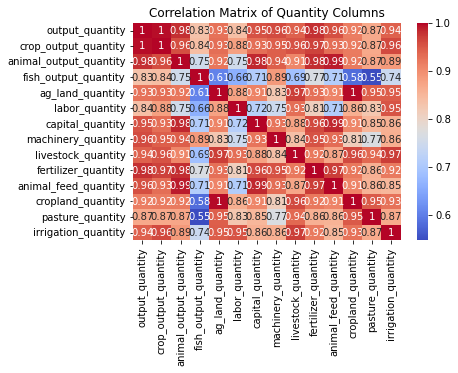

In [68]:
Group22.plot_quantity_correlation(agr_data, agr_data.my_df)

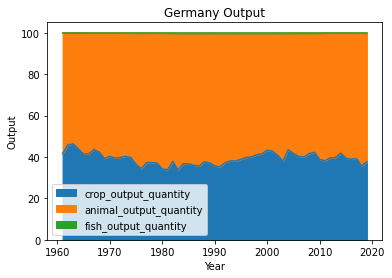

In [69]:
Group22.plot_output_area_chart(agr_data, agr_data.my_df, country="Germany", normalize=True)

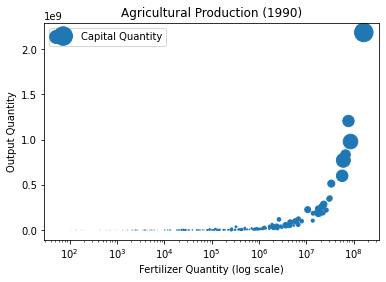

In [4]:
Group22.__gapminder__(agr_data, 1990)